# Processando dados de filmes usando Spark Dataframe com Pyspark

## Instituto Infnet
### prof.: Andre O. Victor
### aluno: Leonardo G Spezia


Primeiramente Instalamos o PySpark (utlizando Python 3.12.1)

In [3]:
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.


Fazemos as configurações iniciais

In [40]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf()


conf.setMaster('local').setAppName('Trabalho de Spark')
sc = SparkContext.getOrCreate(conf)
print(sc.appName)

Trabalho de Spark


Carregamos nosso arquivo

In [41]:
pathOne = "/Users/spezia/Downloads/infnet/aulas-spark/trabalho/"
fileOne = "movies.csv"
conteudoRDD2 = sc.textFile(pathOne+fileOne)

print(conteudoRDD2)

/Users/spezia/Downloads/infnet/aulas-spark/trabalho/movies.csv MapPartitionsRDD[7] at textFile at NativeMethodAccessorImpl.java:0


In [42]:
print(sc.version)
print(sc.pythonVer)
print(sc.master)
print(type(sc))

3.4.3
3.12
local
<class 'pyspark.context.SparkContext'>


Verificamos a versao do Spark

In [46]:
spark = sc
spark.version


'3.4.3'

### Usamos o conjunto de dados movies para resolver o problema a seguir

1. Encontrar o número de registros no dataframe movies
2. Encontrar o número de registros no dataframe ratings
3. Validar se a combinação userId e movieId é única
4. Encontrar a classificação média e a contagem de classificações por movieId usando o dataframe ratings
5. Encontrar os 10 melhores filmes com base nas classificações médias mais altas , utilizando instruções SQL. Considere apenas os filmes que têm pelo menos 100 classificações. Mostre as colunas movieId, title, average rating e rating count.
6. Mostre as visualizações temporárias para a sessão Spark atual
7. Registrar o dataframe movies e o ratings dayaframe como visualização temporária movies e ratings, respectivamente. Verificar se você consegue ver as novas visualizações temporárias que acabou de criar.


Carregamos as funções do Spark para SQL, exemplo: count, avg, explode etc.

In [47]:
from pyspark.sql.functions import *

Localização do movies dataset.

In [45]:

home_dir = "/Users/spezia/Downloads/infnet/aulas-spark/trabalho/"

In [38]:
#contamos a quantidade de registros
conteudoRDD2.count()

407

In [39]:
#vamos que a primeira linha é o cabecalho
conteudoRDD2.first()

'Car;MPG;Cylinders;Displacement;Horsepower;Weight;Acceleration;Model;Origin'

Cria um dataframe a partir do arquivo movies.csv 

In [35]:
movies = (spark.read.format("csv").options(header = True, inferSchema = True).load(home_dir + "movies.csv").cache())
# Keep the dataframe in memory for faster processing 

#sc.textFile(pathOne+fileOne)
#movies = conteudoRDD2

Mostra o esquema do dataframe movies

In [ ]:
movies.printSchema()

#root
# |-- movieId: integer (nullable = true)
# |-- title: string (nullable = true)
# |-- genres: string (nullable = true)


In [6]:
movies.dtypes

[('movieId', 'int'), ('title', 'string'), ('genres', 'string')]

Mostramos um pequeno exemplo do esquema do dataframe movies

In [7]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



Abaixo o numero de registros de nosso dataframe

In [8]:
movies.count()

10329

Criamos um Dataframe de classificação usando o arquivo ratings.csv


In [9]:
ratings = (spark.read.format("csv")
.options(header = True, inferSchema = True)
.load(home_dir + "ratings.csv")
.persist())

Esquema de classificações do Dataframe

In [10]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



Show a few sample values from ratings dataframe

In [11]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     16|   4.0|1217897793|
|     1|     24|   1.5|1217895807|
|     1|     32|   4.0|1217896246|
|     1|     47|   4.0|1217896556|
|     1|     50|   4.0|1217896523|
+------+-------+------+----------+
only showing top 5 rows




Contamos o numero de registros do ratings

In [12]:
ratings.count()

105339


Validar se a combinação movieId e ratingId é um identificador exclusivo na tabela de classificações

In [13]:
ratings.groupBy("movieId", "userId").count().filter("count != 1").show()

+-------+------+-----+
|movieId|userId|count|
+-------+------+-----+
+-------+------+-----+



Não há nenhuma combinação de userId e movieId que ocorra mais de uma vez.


Encontre a classificação média de cada filme para o qual há pelo menos 100 classificações. Ordene o resultado por classificação média em ordem decrescente.

In [14]:
ratings_agg = (ratings
.groupBy(col("movieId"))
.agg(
    count(col("movieId")).alias("count"),
    avg(col("rating")).alias("avg_rating")
))

ratings_agg.show()

+-------+-----+------------------+
|movieId|count|        avg_rating|
+-------+-----+------------------+
|   1580|  172| 3.627906976744186|
|    471|   48|3.6666666666666665|
|   7253|    2|               4.0|
|   3997|   11|               2.5|
|  32460|    1|               4.5|
|  44022|   16|            3.3125|
|  54190|    7| 3.357142857142857|
|    833|   10|              2.95|
|   1591|   33| 2.257575757575758|
|   6357|    5|               3.6|
|   2366|   31| 3.532258064516129|
|   1088|   56| 3.419642857142857|
|   1238|   12|              3.75|
|   4519|   11|3.0454545454545454|
|   1645|   60| 3.566666666666667|
|   8638|   18|3.9722222222222223|
|   3175|   73| 3.712328767123288|
|   2122|   14|2.2142857142857144|
|  26755|    1|               0.5|
|   5803|    7|2.5714285714285716|
+-------+-----+------------------+
only showing top 20 rows



In [15]:
(ratings_agg
.alias("t1")
.join(movies.alias("t2"), col("t1.movieId") == col("t2.movieId"))
.filter("count > 100")
.orderBy(desc("avg_rating"))
.select("t1.movieId", "title", "avg_rating", "count")
.limit(10)
.show())

+-------+--------------------+------------------+-----+
|movieId|               title|        avg_rating|count|
+-------+--------------------+------------------+-----+
|    318|Shawshank Redempt...| 4.454545454545454|  308|
|    858|Godfather, The (1...| 4.392857142857143|  210|
|     50|Usual Suspects, T...| 4.328947368421052|  228|
|   1136|Monty Python and ...|4.3019480519480515|  154|
|    527|Schindler's List ...| 4.296370967741935|  248|
|   1193|One Flew Over the...|4.2727272727272725|  143|
|    608|        Fargo (1996)|4.2711442786069655|  201|
|   2571|  Matrix, The (1999)| 4.264367816091954|  261|
|   1221|Godfather: Part I...| 4.260714285714286|  140|
|   1213|   Goodfellas (1990)|4.2592592592592595|  135|
+-------+--------------------+------------------+-----+



 views  temporarias para essa Spark session

In [16]:
sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|   movies|      false|
| default|  weblogs|      false|
+--------+---------+-----------+



In [17]:
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|   movies|      false|
| default|  weblogs|      false|
|        |   movies|       true|
|        |  ratings|       true|
+--------+---------+-----------+



Usando a instrução SQL, encontramos os 10 melhores filmes com base nas classificações médias mais altas. Considerando apenas os filmes que têm pelo menos 100 classificações. Mostramos as colunas movieId, title, average rating e rating count.

In [18]:
sql("""

select 
    t1.movieId, 
    t1.title, 
    avg(t2.rating) avg_rating, 
    count(1) rating_count 
from movies t1 join ratings t2 on t1.movieId = t2.movieId 
group by t1.movieId, t1.title
having rating_count >= 100
order by avg_rating desc 
limit 10

""").show()

+-------+--------------------+------------------+------------+
|movieId|               title|        avg_rating|rating_count|
+-------+--------------------+------------------+------------+
|    318|Shawshank Redempt...| 4.454545454545454|         308|
|    858|Godfather, The (1...| 4.392857142857143|         210|
|     50|Usual Suspects, T...| 4.328947368421052|         228|
|   1136|Monty Python and ...|4.3019480519480515|         154|
|    527|Schindler's List ...| 4.296370967741935|         248|
|   1193|One Flew Over the...|4.2727272727272725|         143|
|    608|        Fargo (1996)|4.2711442786069655|         201|
|   2571|  Matrix, The (1999)| 4.264367816091954|         261|
|   1221|Godfather: Part I...| 4.260714285714286|         140|
|   1213|   Goodfellas (1990)|4.2592592592592595|         135|
+-------+--------------------+------------------+------------+



# Encontramos a classificação média de cada gênero

In [19]:
genre_avg_rating = (ratings.alias("t1")
.join(movies.alias("t2"), col("t1.movieId") == col("t2.movieId"))
.select(col("rating"), explode(split("genres", r"\|")).alias("genre"))
.groupBy(col("genre"))
.agg(count(col("genre")).alias("count"), avg("rating").alias("avg_rating"))
.orderBy(desc("avg_rating")))

genre_avg_rating.show()

+------------------+-----+------------------+
|             genre|count|        avg_rating|
+------------------+-----+------------------+
|         Film-Noir| 1210|3.9136363636363636|
|               War| 5828|3.7832017844886754|
|           Mystery| 8320| 3.652043269230769|
|             Drama|46960|3.6502661839863713|
|       Documentary| 1206|3.6430348258706466|
|             Crime|18291|3.6423924334372098|
|              IMAX| 3032| 3.641820580474934|
|         Animation| 5966|3.6353503184713376|
|           Musical| 4287|  3.57196174480989|
|           Western| 2314| 3.565687121866897|
|           Romance|19094| 3.544254739708809|
|         Adventure|23076| 3.518027387762177|
|           Fantasy|10889|3.5004591789879695|
|          Thriller|29288|3.4955613220431574|
|            Sci-Fi|16795|3.4544805001488537|
|            Action|31205|3.4514500881269026|
|          Children| 8098|3.4394294887626575|
|            Comedy|38055|3.4209959269478385|
|            Horror| 7983| 3.28109

### Usando matplotlib mostre o gráfico de barras da classificação média para cada gênero

Carregando matplotlib library

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Convertendo o spark dataframe para Pandas Dataframe. 

In [21]:
df = genre_avg_rating.toPandas()
df.head()

genre  count  avg_rating
0    Film-Noir   1210    3.913636
1          War   5828    3.783202
2      Mystery   8320    3.652043
3        Drama  46960    3.650266
4  Documentary   1206    3.643035

Classificação média do enredo para cada gênero

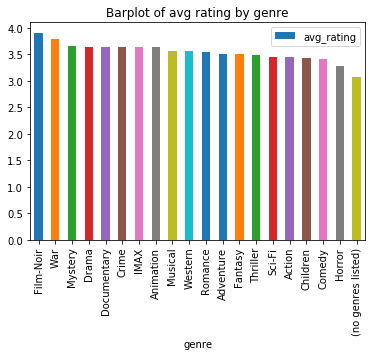

In [22]:
df.plot("genre", "avg_rating", "bar", title = "Barplot of avg rating by genre")

###  Convertendo o RDD para Dataframe
Existem algumas maneiras de cobrir o RDD em um dataframe.
A. Forneça o esquema definido usando o objeto StructType
B. Inferir o esquema

In [65]:
from random import random

In [66]:
rdd = sc.parallelize([random() for _ in range(10)])
rdd.collect()

[7.576205089743215e-05,
 0.5286446509604893,
 0.7090196027486819,
 0.7064680098536666,
 0.8138804138909966,
 0.9456380937096995,
 0.25481721212652253,
 0.9486494217992113,
 0.35200515066138993,
 0.770356992832654]

In [67]:
from pyspark.sql import Row
rddRow = rdd.map(lambda f: Row(f))
spark.createDataFrame(rddRow).toDF("col1").show()

+--------------------+
|                col1|
+--------------------+
|7.576205089743215E-5|
|  0.5286446509604893|
|  0.7090196027486819|
|  0.7064680098536666|
|  0.8138804138909966|
|  0.9456380937096995|
| 0.25481721212652253|
|  0.9486494217992113|
| 0.35200515066138993|
|   0.770356992832654|
+--------------------+



In [68]:
rddRow = rdd.map(lambda f: Row(col1 = f))
df = spark.createDataFrame(rddRow)
df.show()

+--------------------+
|                col1|
+--------------------+
|7.576205089743215E-5|
|  0.5286446509604893|
|  0.7090196027486819|
|  0.7064680098536666|
|  0.8138804138909966|
|  0.9456380937096995|
| 0.25481721212652253|
|  0.9486494217992113|
| 0.35200515066138993|
|   0.770356992832654|
+--------------------+



#### Fornecendo o esquema para converter o RDD em um dataframe

Por padrão, o Spark tentará inferir os nomes das colunas e os tipos por amostragem do objeto de linha RDD. Para controlar esse processo, podemos fornecer o esquema programaticamente.

In [69]:
# Schema created by schema inferencing
rdd = sc.parallelize([
    Row(c1 = 1.0, c2 = None, c3 = None), 
    Row(c1 = None, c2= "Apple", c3 = None)])
df = spark.createDataFrame(rdd, samplingRatio=1.0) # samplingRatio = 1 forces to see all records
df.printSchema()

root
 |-- c1: double (nullable = true)
 |-- c2: string (nullable = true)
 |-- c3: null (nullable = true)



Agora,  já conhecemos o esquema do registro - ele deve ter três colunas. C1, C2 e C3 dos tipos float, string e date, respectivamente.

In [70]:
from pyspark.sql.types import *

In [71]:
schema = StructType([
    StructField("c1", FloatType()),
    StructField("c2", StringType()),
    StructField("c3", DateType()),
])

In [72]:
df = spark.createDataFrame(rdd, schema)
df.printSchema()

root
 |-- c1: float (nullable = true)
 |-- c2: string (nullable = true)
 |-- c3: date (nullable = true)



In [73]:
df.show()

+----+-----+----+
|  c1|   c2|  c3|
+----+-----+----+
| 1.0| null|null|
|null|Apple|null|
+----+-----+----+



In [74]:
moviesRdd = sc.textFile("movielens/movies.csv")
moviesRdd.take(10)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance',
 '5,Father of the Bride Part II (1995),Comedy',
 '6,Heat (1995),Action|Crime|Thriller',
 '7,Sabrina (1995),Comedy|Romance',
 '8,Tom and Huck (1995),Adventure|Children',
 '9,Sudden Death (1995),Action']

In [75]:
moviesRdd.filter(lambda line: len(line.split(",")) != 3).take(10)

['11,"American President, The (1995)",Comedy|Drama|Romance',
 '29,"City of Lost Children, The (Cité des enfants perdus, La) (1995)",Adventure|Drama|Fantasy|Mystery|Sci-Fi',
 '40,"Cry, the Beloved Country (1995)",Drama',
 '50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller',
 '54,"Big Green, The (1995)",Children|Comedy',
 '58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance',
 '59,"Confessional, The (Confessionnal, Le) (1995)",Drama|Mystery',
 '60,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy',
 '73,"Misérables, Les (1995)",Drama|War',
 '78,"Crossing Guard, The (1995)",Action|Crime|Drama|Thriller']

In [76]:
from io import StringIO
import csv
from pyspark.sql.types import Row

def parse_movie(line):
    tokens = [v for v in csv.reader(StringIO(line), delimiter=',')][0]
    fields = tuple(tokens)
    return Row(*tokens)

moviesCleanRdd = (moviesRdd
                  .filter(lambda line: not line.startswith("movieId"))
                  .map(parse_movie)
                 )
df = moviesCleanRdd.toDF().toDF("movieId", "title", "genre")
df.show(10, False) 

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genre                                      |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

In [77]:
schema = StructType([
    StructField("movieId", StringType()),
    StructField("title", StringType()),
    StructField("genres", StringType()),
])

In [78]:
spark.createDataFrame(moviesCleanRdd, schema).show(10, False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

# Tamanho do dataframe in cache

Armazenamos em cache o stocks.csv no formato RDD e fazemos o mesmo no formato Dataframe e compare a utilização da memória.

In [87]:
stocksRdd = sc.textFile("stocks")
stocksRdd.cache().count()

1857093

Verificamos a tabela de armazenamento no Spark Web UI.  Podemos encontrar o Spark Web UI  abaixo.

In [88]:
sc.uiWebUrl

'http://quickstart.cloudera:4041'

In [89]:
stocksDf = spark.read.option("header", True).option("inferSchema", True).csv("stocks")
stocksDf.cache()
stocksDf.count()

1857092